In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q peft accelerate transformers



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.9 MB/s eta 0:00:00


In [ ]:
!cp -r /content/drive/MyDrive/fine_tune_data/final_train /content/

In [ ]:
!cp -r /content/drive/MyDrive/fine_tune_val/final_val /content/

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
from torchvision.transforms.functional import resize

from segment_anything import SamPredictor, sam_model_registry
from peft import PeftModel
from sklearn.metrics import jaccard_score, f1_score


In [ ]:
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))
        bn = self.bottleneck(self.pool4(d4))
        x = self.up4(bn)
        x = self.conv4(torch.cat([x, d4], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, d3], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, d2], dim=1))
        x = self.up1(x)
        x = self.conv1(torch.cat([x, d1], dim=1))
        return torch.sigmoid(self.final(x))

def calculate_metrics(preds, masks):
    preds = (preds > 0.5).float()
    masks = (masks > 0.5).float()
    preds_np = preds.cpu().numpy().flatten()
    masks_np = masks.cpu().numpy().flatten()
    iou = jaccard_score(masks_np, preds_np, zero_division=1)
    dice = f1_score(masks_np, preds_np, zero_division=1)
    return iou, dice


In [ ]:
# Tạo thư mục nếu chưa có
!mkdir -p /content/drive/MyDrive/checkpoints

# Tải sam_vit_b.pth từ repo chính thức của Meta AI
!wget -O /content/drive/MyDrive/checkpoints/sam_vit_b.pth \
    https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


--2025-06-17 13:20:54--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.84, 13.35.37.111, 13.35.37.123, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘/content/drive/MyDrive/checkpoints/sam_vit_b.pth’

/content/drive/MyDr 100%[===================>] 357.67M  83.0MB/s    in 4.2s    

2025-06-17 13:20:58 (85.3 MB/s) - ‘/content/drive/MyDrive/checkpoints/sam_vit_b.pth’ saved [375042383/375042383]



In [ ]:
# Tạo một instance của UNet model và chuyển nó đến DEVICE
unet = UNet().to(DEVICE)

checkpoint = torch.load("/content/drive/MyDrive/unet_mri_best.pth", map_location=DEVICE)

# Tự kiểm tra key
if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    unet.load_state_dict(checkpoint["model_state_dict"])
else:
    unet.load_state_dict(checkpoint)

unet.eval()
print("✅ UNet đã load thành công và chuyển sang chế độ eval.")

✅ UNet đã load thành công và chuyển sang chế độ eval.


In [ ]:
import torch
from segment_anything import sam_model_registry, SamPredictor
from peft import PeftModel

# ==== Cấu hình ====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAM_CHECKPOINT = "/content/drive/MyDrive/checkpoints/sam_vit_b.pth"  # Đường dẫn mô hình gốc
LORA_ADAPTER_PATH = "/content/drive/MyDrive/fine_tune_data/sam_lora_with_imgenc"  # Thư mục chứa adapter đã fine-tune
MODEL_TYPE = "vit_b"  # hoặc vit_h / vit_l nếu bạn dùng mô hình lớn hơn

# ==== Load mô hình SAM gốc ====
sam_base = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT).to(DEVICE)
sam_base.eval()
sam_original_predictor = SamPredictor(sam_base)

# ==== Load mô hình SAM + LoRA ====
sam_lora = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT).to(DEVICE)
sam_lora = PeftModel.from_pretrained(sam_lora, LORA_ADAPTER_PATH)
sam_lora.eval()
sam_lora_predictor = SamPredictor(sam_lora)



In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score, f1_score
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision.transforms as T
from PIL import Image
import cv2  # vẫn cần cho resize mask dạng nhị phân nếu muốn giữ pixel value rõ

# ========= Tiền xử lý =========
def preprocess_image(img_path, target_size=(256, 256), return_tensor=False):
    image = Image.open(img_path).convert("RGB")
    image = image.resize(target_size, resample=Image.BILINEAR)
    if return_tensor:
        return T.ToTensor()(image).unsqueeze(0)  # Trả về tensor [1, 3, H, W]
    return np.array(image)  # Trả về ảnh NumPy

def preprocess_mask(mask_path):
    mask = Image.open(mask_path).convert("L")  # đọc grayscale bằng PIL
    mask = mask.resize((256, 256), resample=Image.NEAREST)  # Resize khớp ảnh
    mask = np.array(mask)
    mask = (mask > 127).astype(np.uint8)
    return mask

# ========= Dự đoán =========
def predict_mask_unet(image_tensor, model):
    with torch.no_grad():
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        pred = model(image_tensor.to(DEVICE))
        pred = torch.sigmoid(pred)
        pred = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    return pred

def predict_mask_sam(image_pil, predictor):
    image_np = np.array(image_pil)  # Convert PIL -> NumPy
    predictor.set_image(image_np)
    H, W = image_np.shape[:2]
    center_point = np.array([[W // 2, H // 2]])
    center_label = np.array([1])
    masks, scores, _ = predictor.predict(
        point_coords=center_point,
        point_labels=center_label,
        multimask_output=False
    )
    return masks[0].astype(np.uint8)

# ========= So sánh =========
def compare_models(val_images, val_masks, num_samples=5):
    dice_scores = {"unet": [], "sam": [], "sam_lora": []}
    iou_scores = {"unet": [], "sam": [], "sam_lora": []}

    for i in tqdm(range(num_samples)):
        img_path = val_images[i]
        mask_path = val_masks[i]

        image_np = preprocess_image(img_path)
        mask = preprocess_mask(mask_path)
        image_pil = Image.fromarray(image_np)

        # --- U-Net ---
        input_tensor = T.ToTensor()(image_np).to(DEVICE)
        pred_unet = predict_mask_unet(input_tensor, unet)

        # --- SAM ---
        pred_sam = predict_mask_sam(image_pil, sam_original_predictor)

        # --- SAM + LoRA ---
        pred_sam_lora = predict_mask_sam(image_pil, sam_lora_predictor)

        # Resize các mask về cùng kích thước mask gốc nếu cần (dù ở đây đã resize rồi)
        H, W = mask.shape
        pred_unet = cv2.resize(pred_unet, (W, H), interpolation=cv2.INTER_NEAREST)
        pred_sam = cv2.resize(pred_sam, (W, H), interpolation=cv2.INTER_NEAREST)
        pred_sam_lora = cv2.resize(pred_sam_lora, (W, H), interpolation=cv2.INTER_NEAREST)

        # Tính Dice và IoU
        for name, pred in zip(["unet", "sam", "sam_lora"], [pred_unet, pred_sam, pred_sam_lora]):
            dice = f1_score(mask.flatten(), pred.flatten(), zero_division=1)
            iou = jaccard_score(mask.flatten(), pred.flatten(), zero_division=1)
            dice_scores[name].append(dice)
            iou_scores[name].append(iou)

    # In kết quả
    for name in ["unet", "sam", "sam_lora"]:
        print(f"{name.upper()} - Dice: {np.mean(dice_scores[name]):.4f}, IoU: {np.mean(iou_scores[name]):.4f}")

    # Biểu đồ
    plt.figure(figsize=(8, 4))
    models = ['U-Net', 'SAM', 'SAM + LoRA']
    avg_dice = [np.mean(dice_scores[m]) for m in ['unet', 'sam', 'sam_lora']]
    avg_iou = [np.mean(iou_scores[m]) for m in ['unet', 'sam', 'sam_lora']]
    x = np.arange(len(models))
    plt.bar(x - 0.2, avg_dice, width=0.4, label='Dice')
    plt.bar(x + 0.2, avg_iou, width=0.4, label='IoU')
    plt.xticks(x, models)
    plt.ylabel("Score")
    plt.title("So sánh U-Net vs SAM vs SAM + LoRA")
    plt.legend()
    plt.show()


✅ Số ảnh: 478
✅ Số mask: 478
✅ Số cặp khớp: 478


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

UNET - Dice: 0.6643, IoU: 0.5115
SAM - Dice: 0.7835, IoU: 0.6793
SAM_LORA - Dice: 0.8196, IoU: 0.7116


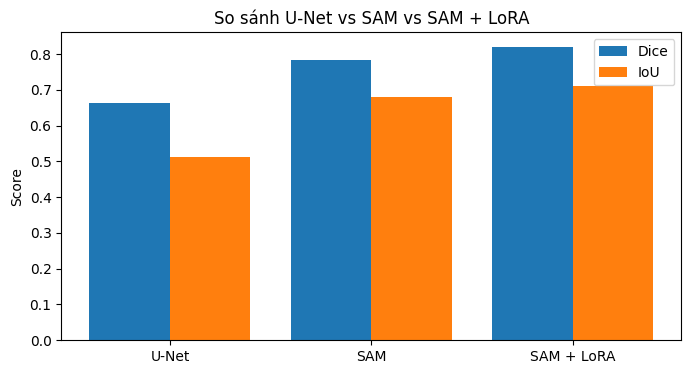

In [ ]:
from glob import glob
import os
import torchvision.transforms as T

# ==== Bước 1: Load và khớp ảnh + mask ====
val_images_all = sorted(glob("/content/final_val/images/*.jpg"))
val_masks_all = sorted(glob("/content/final_val/masks/*.png"))

# Đảm bảo tên ảnh và mask khớp nhau
image_names = [os.path.splitext(os.path.basename(p))[0] for p in val_images_all]
mask_names = [os.path.splitext(os.path.basename(p))[0] for p in val_masks_all]

# Tạo danh sách khớp (ảnh, mask)
matched_pairs = []
for name in image_names:
    if name in mask_names:
        img_path = f"/content/final_val/images/{name}.jpg"
        mask_path = f"/content/final_val/masks/{name}.png"
        matched_pairs.append((img_path, mask_path))

# Tách thành 2 danh sách ảnh và mask
val_images = [pair[0] for pair in matched_pairs]
val_masks = [pair[1] for pair in matched_pairs]

print(f"✅ Số ảnh: {len(val_images)}")
print(f"✅ Số mask: {len(val_masks)}")
print(f"✅ Số cặp khớp: {len(matched_pairs)}")

# ==== Bước 2: Gọi hàm so sánh mô hình ====
# Giả sử bạn đã load các mô hình:
# - unet
# - sam_original_predictor
# - sam_lora_predictor
# - DEVICE = "cuda" nếu có GPU, hoặc "cpu"

# Số lượng mẫu bạn muốn so sánh
num_samples = min(10, len(val_images))

# Gọi hàm đánh giá
compare_models(val_images, val_masks, num_samples=num_samples)


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import cv2
import random

# ========= Tiền xử lý =========
def load_image_mask_pair(image_path, mask_path):
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    return image, mask

def prepare_image_tensor(image, target_size=(256, 256)):
    image_resized = image.resize(target_size)
    tensor = T.ToTensor()(image_resized).unsqueeze(0).to(DEVICE)
    return tensor

def postprocess_mask(mask_tensor):
    mask_np = mask_tensor.squeeze().detach().cpu().numpy()
    if mask_np.max() > 1.0:
        mask_np = mask_np / 255.0
    return (mask_np > 0.5).astype(np.uint8)

# ========= Dự đoán =========
def predict_mask_unet(image_tensor, model):
    with torch.no_grad():
        pred = model(image_tensor)
        return postprocess_mask(pred)

def predict_mask_sam(image_pil, predictor):
    image_np = np.array(image_pil)  # Chuyển từ PIL → NumPy
    predictor.set_image(image_np)
    H, W = image_np.shape[:2]

    # Tạo điểm hướng dẫn ở giữa ảnh
    center_point = np.array([[W // 2, H // 2]])
    center_label = np.array([1])  # 1: foreground

    masks, scores, _ = predictor.predict(
        point_coords=center_point,
        point_labels=center_label,
        multimask_output=False
    )
    return masks[0].astype(np.uint8)

# ========= Hàm hiển thị & so sánh =========
def compare_models_all(val_images, val_masks, num_samples=5, display_size=(256, 256), seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    indices = np.random.choice(len(val_images), num_samples, replace=False)

    for idx in indices:
        img_path = val_images[idx]
        mask_path = val_masks[idx]

        # Load ảnh và mask
        image_pil, mask_pil = load_image_mask_pair(img_path, mask_path)
        mask_np = np.array(mask_pil.resize(display_size, resample=Image.NEAREST)).astype(np.uint8)

        # Dự đoán UNet
        input_tensor = prepare_image_tensor(image_pil, target_size=display_size)
        pred_unet = predict_mask_unet(input_tensor, unet)

        # Dự đoán SAM & SAM LoRA
        pred_sam = predict_mask_sam(image_pil, sam_original_predictor)
        pred_lora = predict_mask_sam(image_pil, sam_lora_predictor)

        # Resize để đồng nhất kích thước
        pred_sam = cv2.resize(pred_sam.astype(np.uint8), display_size, interpolation=cv2.INTER_NEAREST)
        pred_lora = cv2.resize(pred_lora.astype(np.uint8), display_size, interpolation=cv2.INTER_NEAREST)

        # Resize ảnh gốc
        image_resized = image_pil.resize(display_size)

        # === Tính Dice & IoU ===
        from sklearn.metrics import f1_score, jaccard_score

        def compute_metrics(pred, gt):
            pred_bin = (pred > 0).astype(np.uint8)
            gt_bin = (gt > 0).astype(np.uint8)
            return {
                "Dice": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1, average="binary"),
                "IoU": jaccard_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1, average="binary")
            }


        metrics_unet = compute_metrics(pred_unet, mask_np)
        metrics_sam = compute_metrics(pred_sam, mask_np)
        metrics_lora = compute_metrics(pred_lora, mask_np)

        # === Hiển thị ảnh & kết quả ===
        titles = [
            "Ảnh gốc",
            "Ground Truth",
            f"U-Net\nDice: {metrics_unet['Dice']:.3f}\nIoU: {metrics_unet['IoU']:.3f}",
            f"SAM\nDice: {metrics_sam['Dice']:.3f}\nIoU: {metrics_sam['IoU']:.3f}",
            f"SAM + LoRA\nDice: {metrics_lora['Dice']:.3f}\nIoU: {metrics_lora['IoU']:.3f}"
        ]
        masks = [image_resized, mask_np, pred_unet, pred_sam, pred_lora]

        plt.figure(figsize=(16, 3.5))
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            ax.set_title(titles[i], fontsize=10)
            ax.axis("off")
            if i == 0:
                ax.imshow(masks[i])  # RGB
            else:
                ax.imshow(masks[i], cmap="gray")
        plt.tight_layout()
        plt.show()


In [ ]:
from sklearn.metrics import jaccard_score, f1_score

def compute_metrics(gt_mask, pred_mask):
    gt_flat = (gt_mask.flatten() > 0).astype(np.uint8)  # ép về 0/1
    pred_flat = (pred_mask.flatten() > 0).astype(np.uint8)

    dice = f1_score(gt_flat, pred_flat, average='binary', zero_division=1)
    iou = jaccard_score(gt_flat, pred_flat, average='binary', zero_division=1)
    return dice, iou

def compare_models(val_images, val_masks, num_samples=5, box_mode="full"):
    dice_scores = {"unet": [], "sam": [], "sam_lora": []}
    iou_scores = {"unet": [], "sam": [], "sam_lora": []}

    for i in tqdm(range(num_samples)):
        img_path = val_images[i]
        mask_path = val_masks[i]

        image = preprocess_image(img_path)
        mask = preprocess_mask(mask_path)

        # --- U-Net ---
        input_tensor = T.ToTensor()(image).to(DEVICE)
        pred_unet = predict_mask_unet(input_tensor, unet)

        # --- SAM gốc ---
        pred_sam = predict_mask_sam(image, sam_original_predictor, box_mode=box_mode, gt_mask=mask)

        # --- SAM + LoRA ---
        pred_sam_lora = predict_mask_sam(image, sam_lora_predictor, box_mode=box_mode, gt_mask=mask)

        # Resize về size của mask
        H, W = mask.shape
        pred_unet = cv2.resize(pred_unet, (W, H), interpolation=cv2.INTER_NEAREST)
        pred_sam = cv2.resize(pred_sam, (W, H), interpolation=cv2.INTER_NEAREST)
        pred_sam_lora = cv2.resize(pred_sam_lora, (W, H), interpolation=cv2.INTER_NEAREST)

        # Tính Dice và IoU
        for name, pred in zip(["unet", "sam", "sam_lora"], [pred_unet, pred_sam, pred_sam_lora]):
            dice = f1_score(mask.flatten(), pred.flatten(), zero_division=1)
            iou = jaccard_score(mask.flatten(), pred.flatten(), zero_division=1)
            dice_scores[name].append(dice)
            iou_scores[name].append(iou)

    # In kết quả trung bình
    for name in ["unet", "sam", "sam_lora"]:
        print(f"{name.upper()} - Dice: {np.mean(dice_scores[name]):.4f}, IoU: {np.mean(iou_scores[name]):.4f}")

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 4))
    models = ['U-Net', 'SAM', 'SAM + LoRA']
    avg_dice = [np.mean(dice_scores[m]) for m in ['unet', 'sam', 'sam_lora']]
    avg_iou = [np.mean(iou_scores[m]) for m in ['unet', 'sam', 'sam_lora']]

    x = np.arange(len(models))
    plt.bar(x - 0.2, avg_dice, width=0.4, label='Dice')
    plt.bar(x + 0.2, avg_iou, width=0.4, label='IoU')
    plt.xticks(x, models)
    plt.ylabel("Score")
    plt.title(f"So sánh U-Net vs SAM vs SAM + LoRA (Box: {box_mode})")
    plt.legend()
    plt.show()


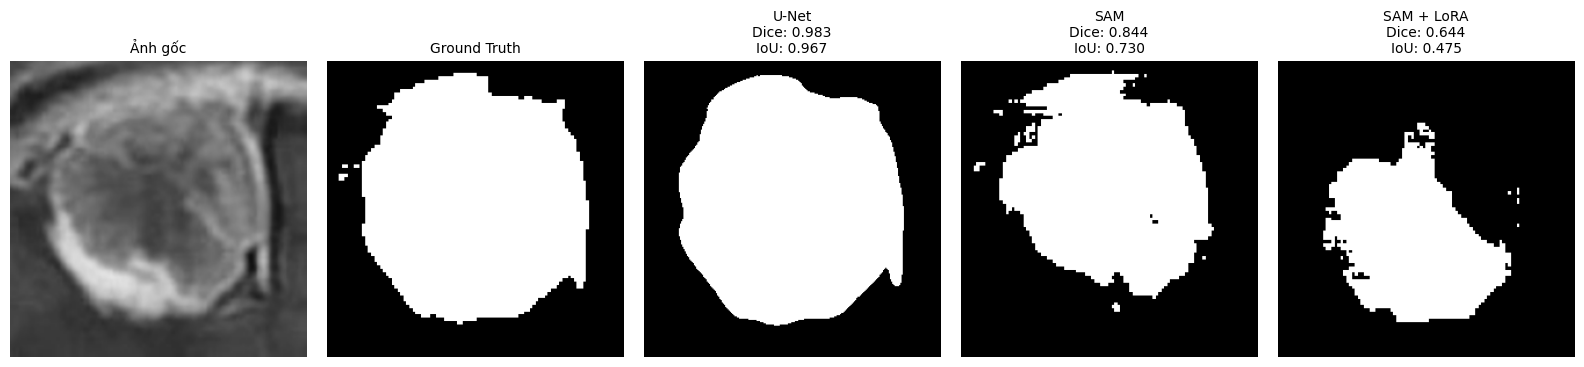

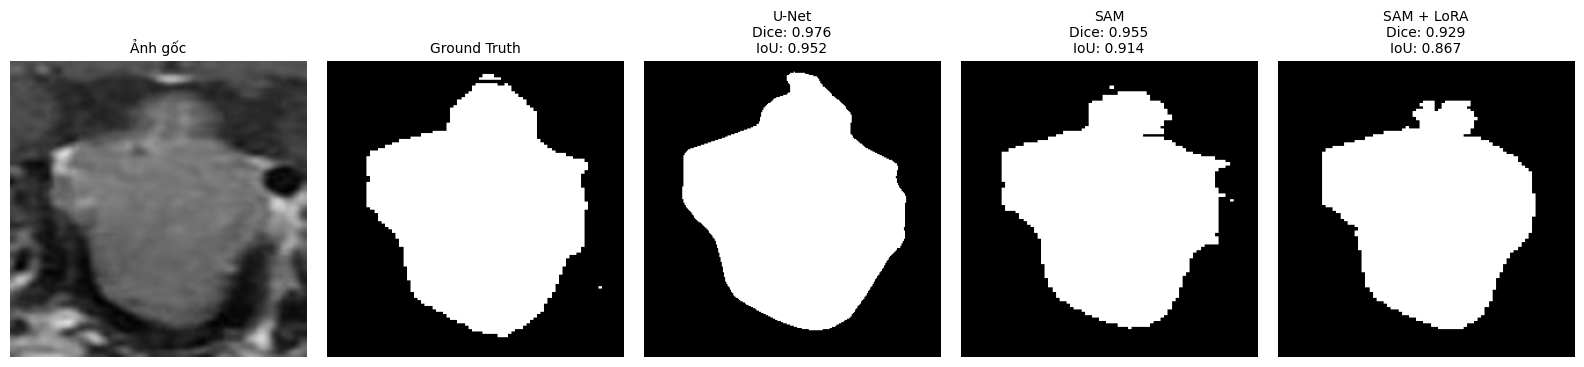

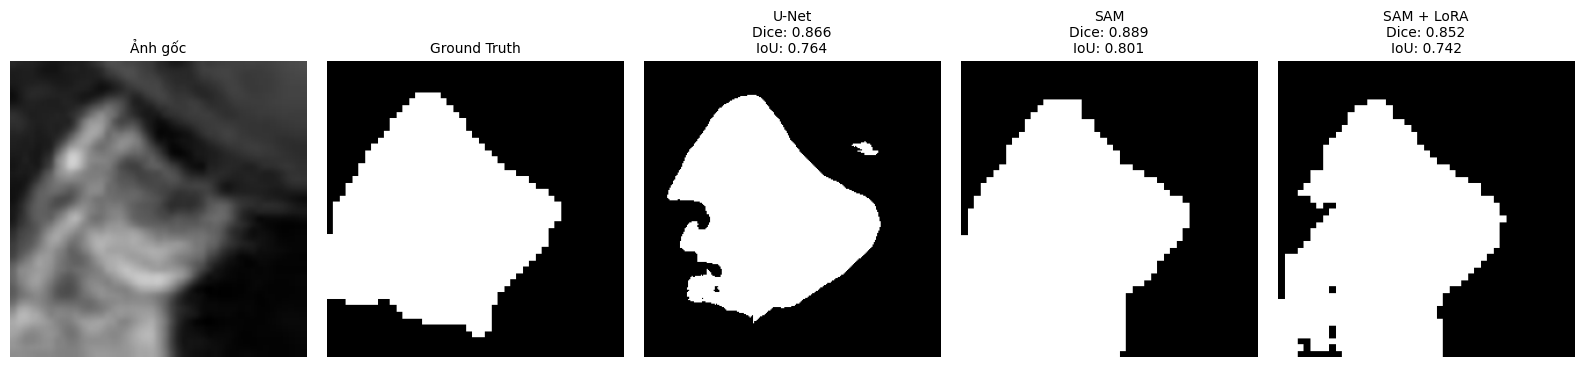

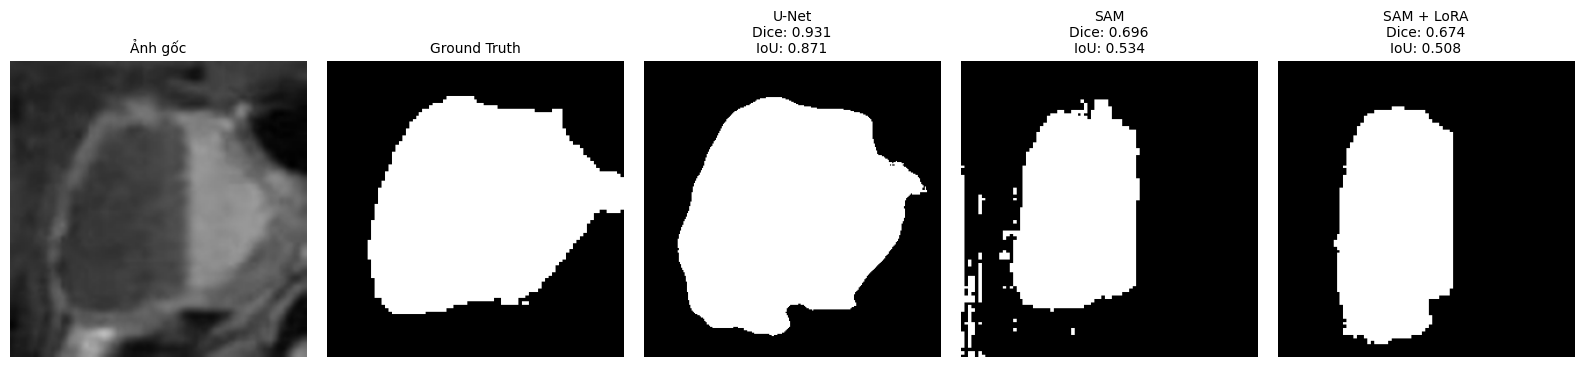

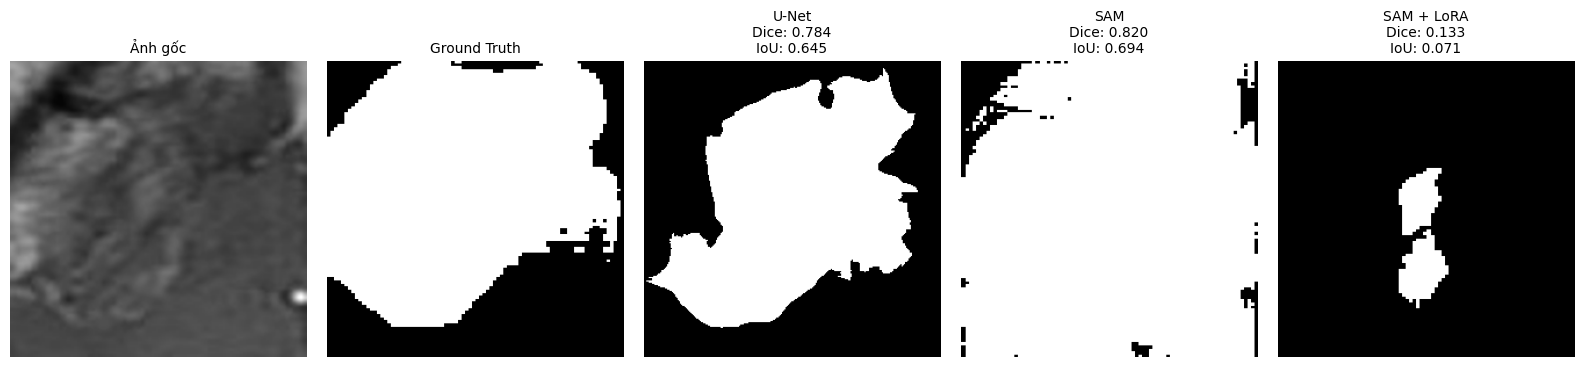

In [ ]:
compare_models_all(val_images, val_masks, num_samples=5, display_size=(256, 256))


In [ ]:
def combine_masks(mask_unet, mask_sam_lora, mode="avg"):
    if mode == "and":
        return (mask_unet & mask_sam_lora).astype(np.uint8)
    elif mode == "or":
        return (mask_unet | mask_sam_lora).astype(np.uint8)
    elif mode == "avg":
        return ((mask_unet + mask_sam_lora) / 2.0 > 0.5).astype(np.uint8)
    else:
        raise ValueError("Chọn mode: 'and', 'or', hoặc 'avg'")


In [ ]:
def compare_combined(val_images, val_masks, num_samples=5, display_size=(256, 256), combine_mode="avg"):
    indices = np.random.choice(len(val_images), num_samples, replace=False)

    for idx in indices:
        img_path = val_images[idx]
        mask_path = val_masks[idx]

        image_pil, mask_pil = load_image_mask_pair(img_path, mask_path)
        mask_np = np.array(mask_pil.resize(display_size, resample=Image.NEAREST)).astype(np.uint8)

        input_tensor = prepare_image_tensor(image_pil, target_size=display_size)
        pred_unet = predict_mask_unet(input_tensor, unet)
        pred_lora = predict_mask_sam(image_pil, sam_lora_predictor)
        pred_lora = cv2.resize(pred_lora.astype(np.uint8), display_size, interpolation=cv2.INTER_NEAREST)

        pred_combined = combine_masks(pred_unet, pred_lora, mode=combine_mode)

        image_resized = image_pil.resize(display_size)

        # Tính metric
        def compute_metrics(pred, gt):
            pred_bin = (pred > 0).astype(np.uint8)
            gt_bin = (gt > 0).astype(np.uint8)
            return {
                "Dice": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1),
                "IoU": jaccard_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1)
            }

        metrics_unet = compute_metrics(pred_unet, mask_np)
        metrics_lora = compute_metrics(pred_lora, mask_np)
        metrics_comb = compute_metrics(pred_combined, mask_np)

        # Hiển thị
        titles = [
            "Ảnh gốc",
            "Ground Truth",
            f"U-Net\nDice: {metrics_unet['Dice']:.3f}",
            f"SAM + LoRA\nDice: {metrics_lora['Dice']:.3f}",
            f"Kết hợp ({combine_mode})\nDice: {metrics_comb['Dice']:.3f}"
        ]
        masks = [image_resized, mask_np, pred_unet, pred_lora, pred_combined]

        plt.figure(figsize=(16, 3.5))
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            ax.set_title(titles[i], fontsize=10)
            ax.axis("off")
            if i == 0:
                ax.imshow(masks[i])
            else:
                ax.imshow(masks[i], cmap="gray")
        plt.tight_layout()
        plt.show()


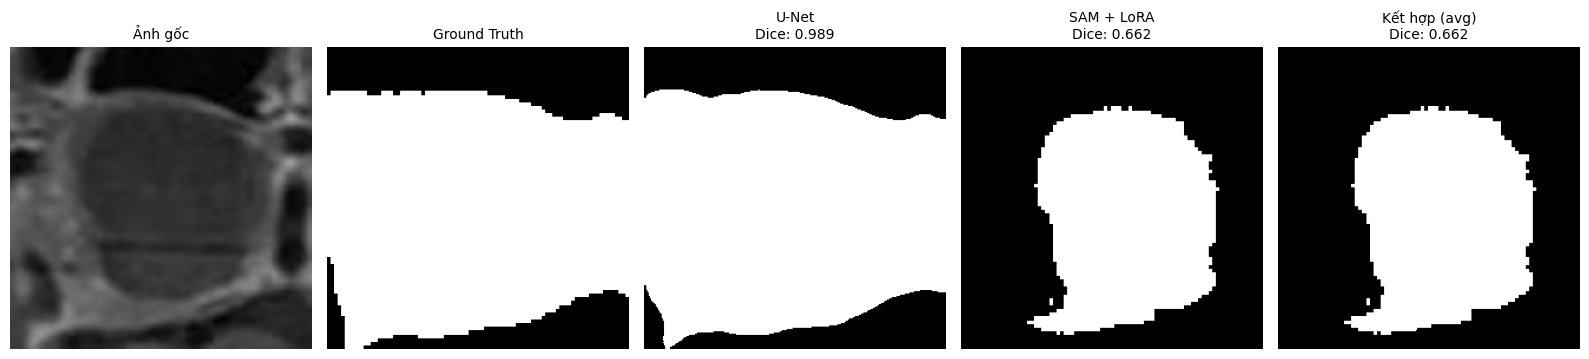

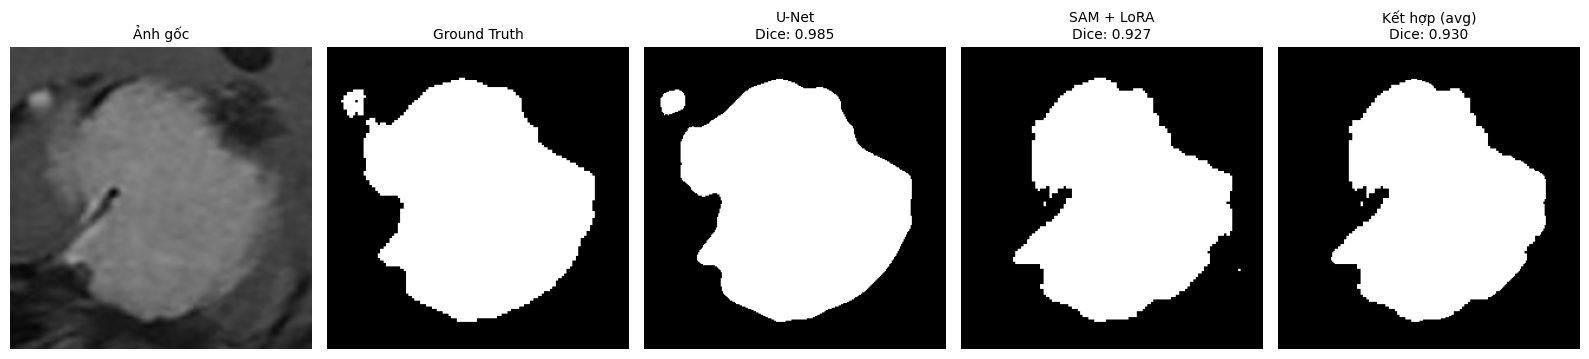

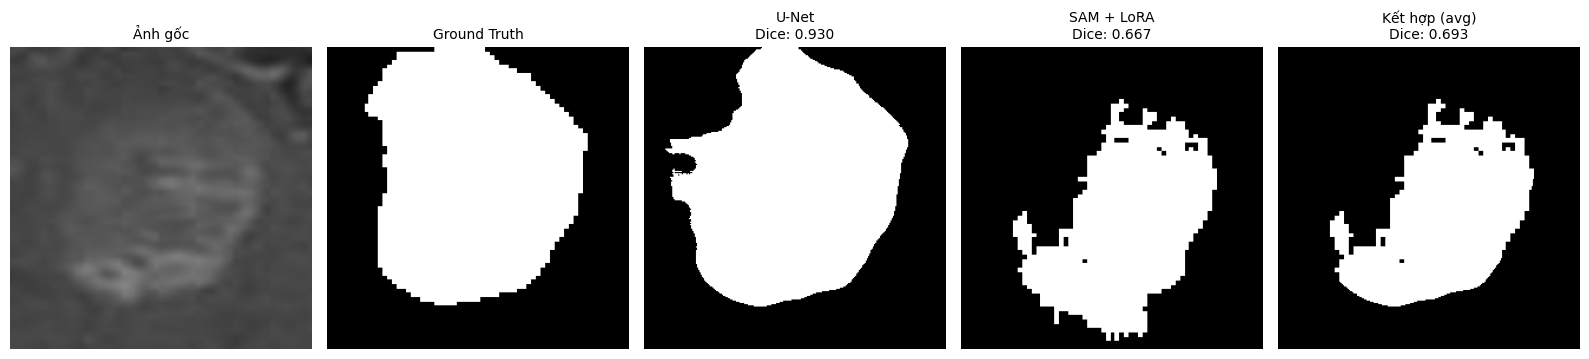

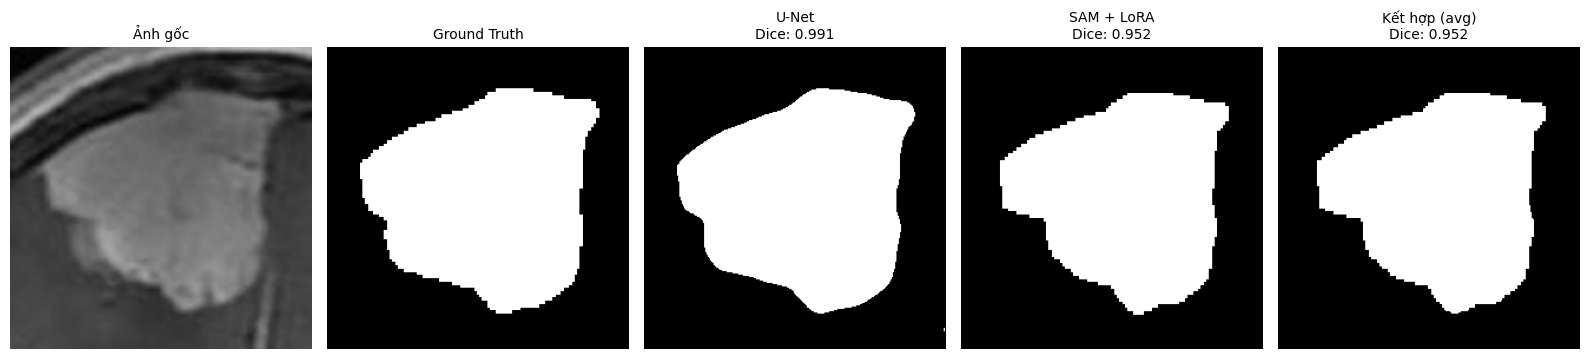

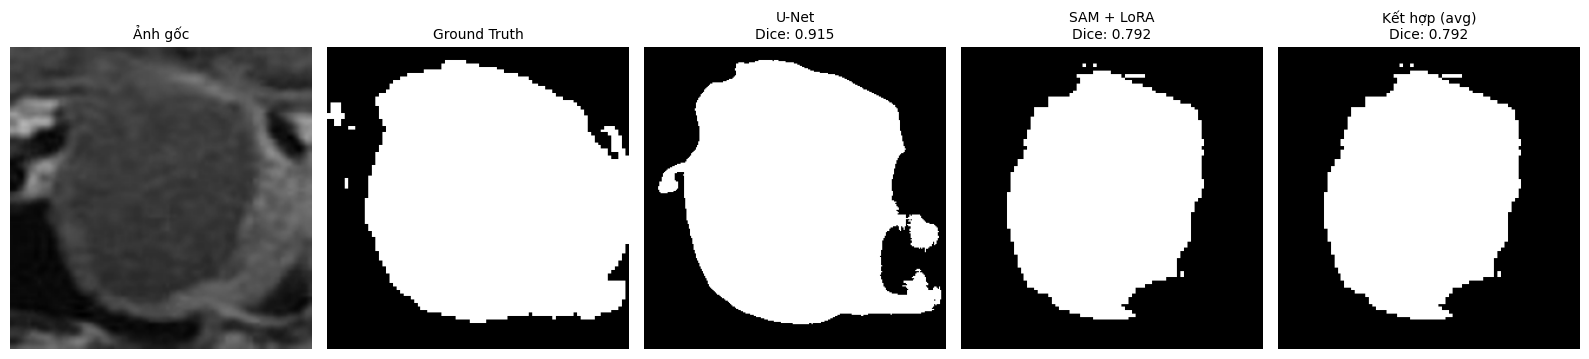

In [ ]:
compare_combined(val_images, val_masks, num_samples=5, combine_mode="avg")


In [ ]:
def compare_combined(val_images, val_masks, num_samples=5, display_size=(256, 256), combine_mode="avg", alpha=0.5):
    indices = np.random.choice(len(val_images), num_samples, replace=False)

    for idx in indices:
        img_path = val_images[idx]
        mask_path = val_masks[idx]

        image_pil, mask_pil = load_image_mask_pair(img_path, mask_path)
        mask_np = np.array(mask_pil.resize(display_size, resample=Image.NEAREST)).astype(np.uint8)

        input_tensor = prepare_image_tensor(image_pil, target_size=display_size)
        pred_unet = predict_mask_unet(input_tensor, unet)
        pred_lora = predict_mask_sam(image_pil, sam_lora_predictor)
        pred_lora = cv2.resize(pred_lora.astype(np.uint8), display_size, interpolation=cv2.INTER_NEAREST)

        # Kết hợp mask
        pred_combined = combine_masks(pred_unet, pred_lora, mode=combine_mode, alpha=alpha)

        image_resized = image_pil.resize(display_size)

        # Tính metric
        def compute_metrics(pred, gt):
            pred_bin = (pred > 0).astype(np.uint8)
            gt_bin = (gt > 0).astype(np.uint8)
            return {
                "Dice": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1),
                "IoU": jaccard_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1)
            }

        metrics_unet = compute_metrics(pred_unet, mask_np)
        metrics_lora = compute_metrics(pred_lora, mask_np)
        metrics_comb = compute_metrics(pred_combined, mask_np)

        # Hiển thị
        if combine_mode == "avg_weighted":
            comb_title = f"Kết hợp (avg_weighted α={alpha})\nDice: {metrics_comb['Dice']:.3f}"
        else:
            comb_title = f"Kết hợp ({combine_mode})\nDice: {metrics_comb['Dice']:.3f}"

        titles = [
            "Ảnh gốc",
            "Ground Truth",
            f"U-Net\nDice: {metrics_unet['Dice']:.3f}",
            f"SAM + LoRA\nDice: {metrics_lora['Dice']:.3f}",
            comb_title
        ]
        masks = [image_resized, mask_np, pred_unet, pred_lora, pred_combined]

        plt.figure(figsize=(16, 3.5))
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            ax.set_title(titles[i], fontsize=10)
            ax.axis("off")
            if i == 0:
                ax.imshow(masks[i])
            else:
                ax.imshow(masks[i], cmap="gray")
        plt.tight_layout()
        plt.show()


In [ ]:
def combine_masks(mask_unet, mask_sam_lora, mode="avg", alpha=0.5):
    if mode == "avg":
        combined = (mask_unet + mask_sam_lora) / 2
        return (combined > 0.5).astype(np.uint8)
    elif mode == "and":
        return (mask_unet & mask_sam_lora).astype(np.uint8)
    elif mode == "or":
        return (mask_unet | mask_sam_lora).astype(np.uint8)
    elif mode == "avg_weighted":
        combined = alpha * mask_unet + (1 - alpha) * mask_sam_lora
        return (combined > 0.5).astype(np.uint8)
    else:
        raise ValueError(f"Chế độ kết hợp không hợp lệ: {mode}")


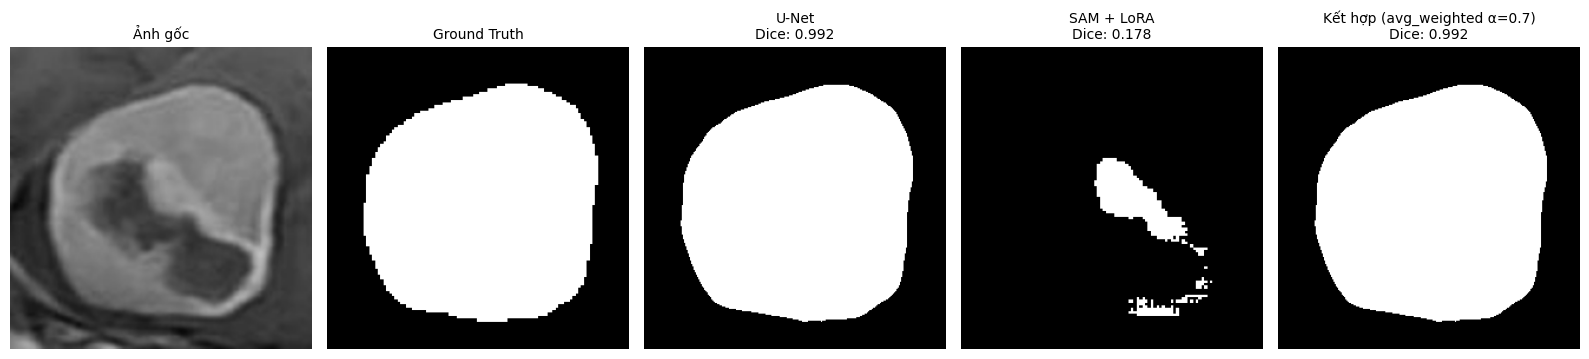

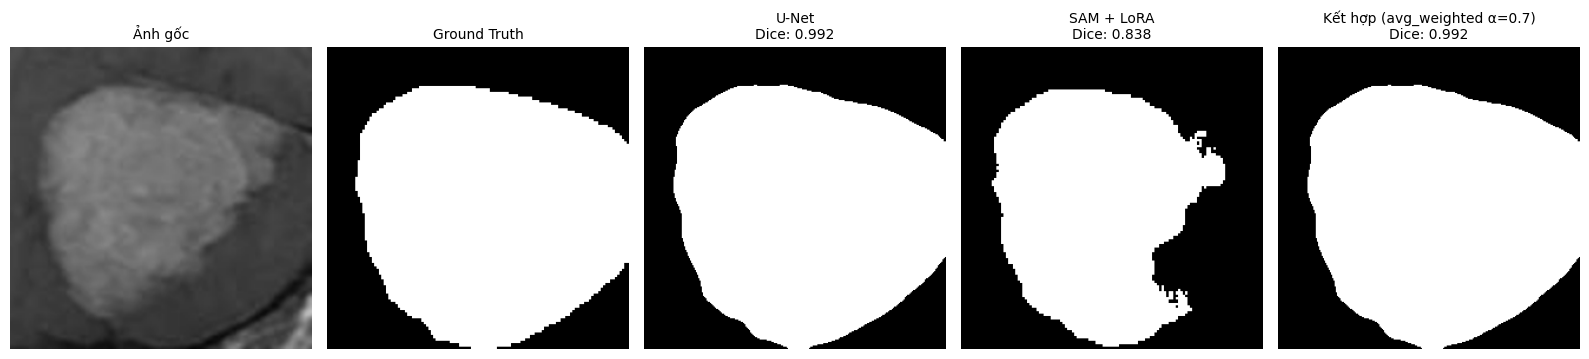

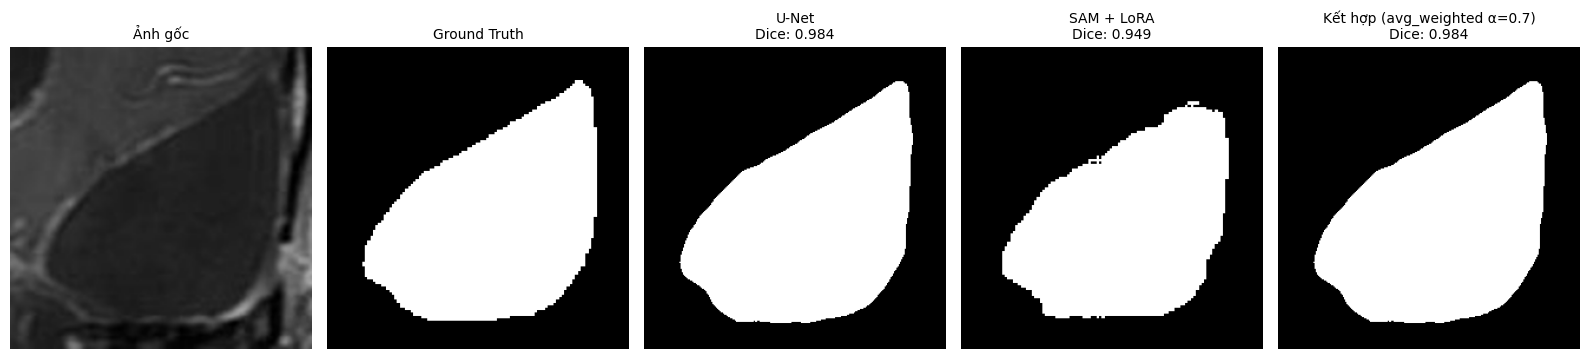

In [ ]:
compare_combined(val_images, val_masks, num_samples=3, combine_mode="avg_weighted", alpha=0.7)



🔍 Thử kết hợp với alpha = 0.1


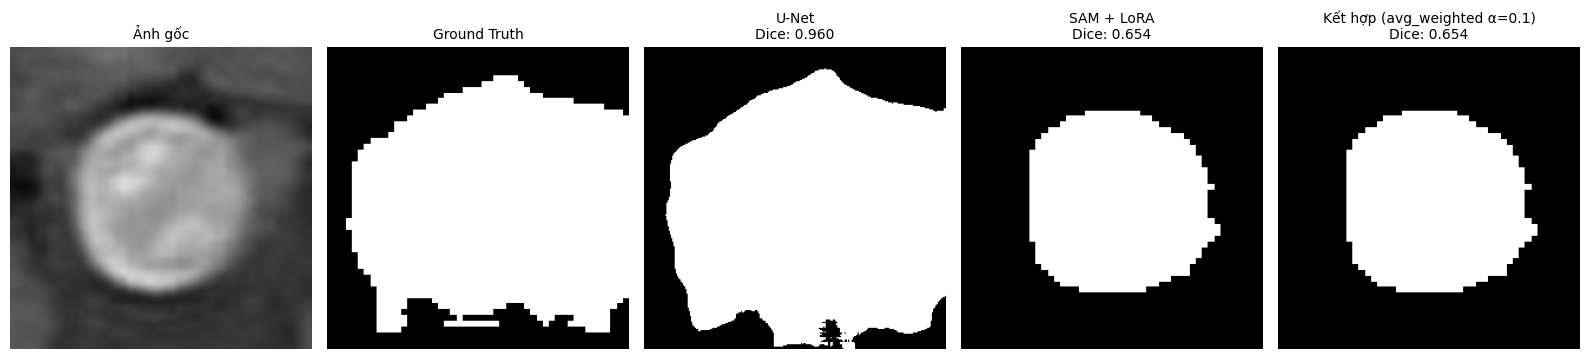

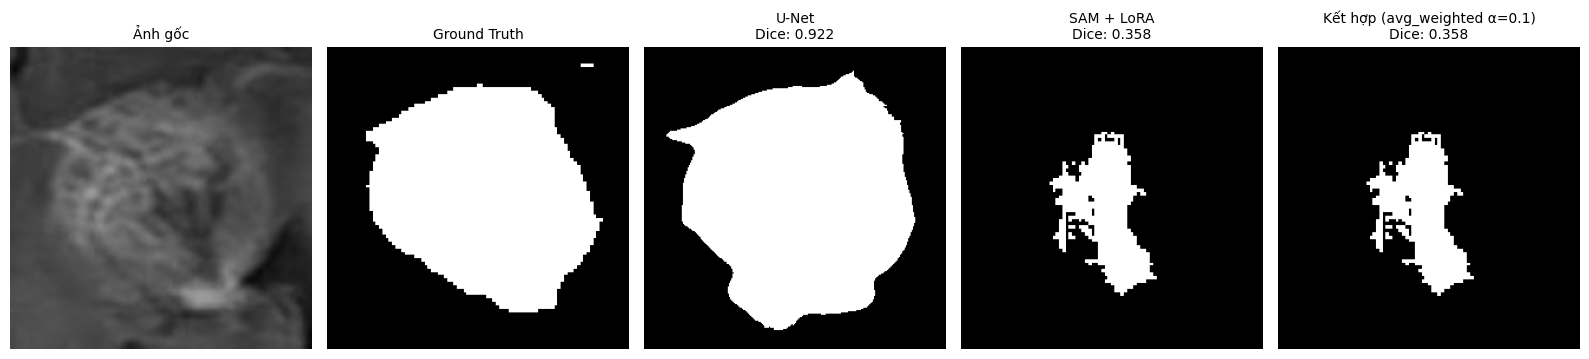


🔍 Thử kết hợp với alpha = 0.3


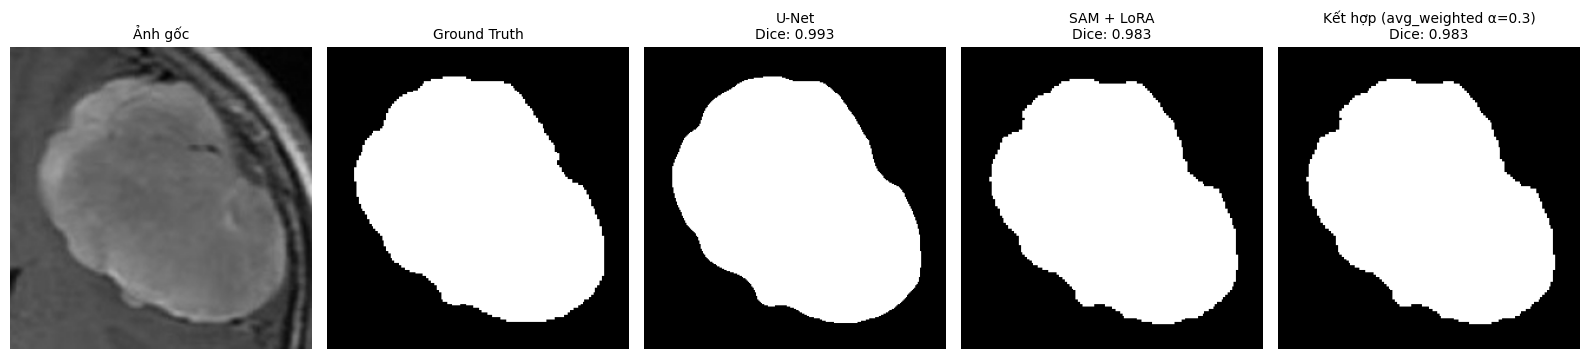

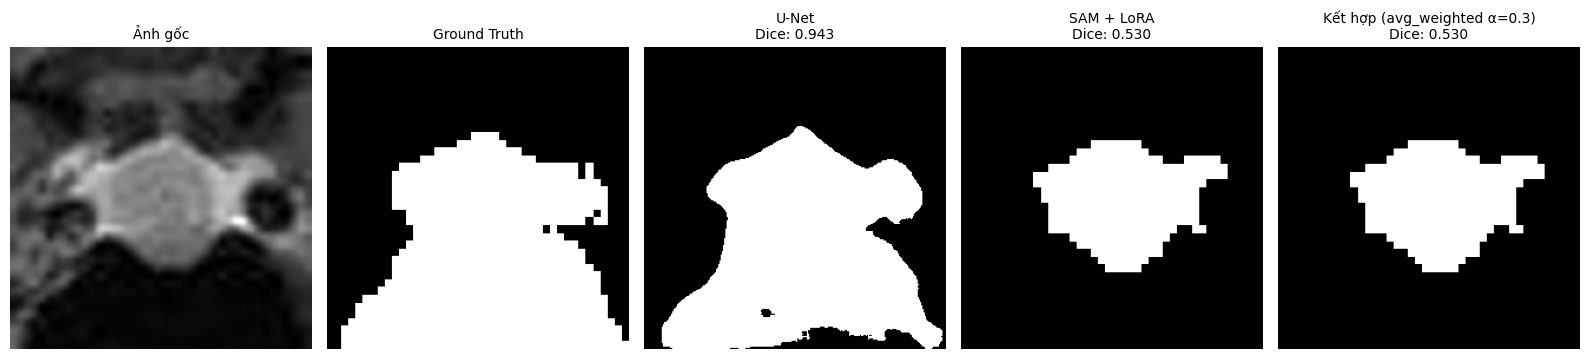


🔍 Thử kết hợp với alpha = 0.5


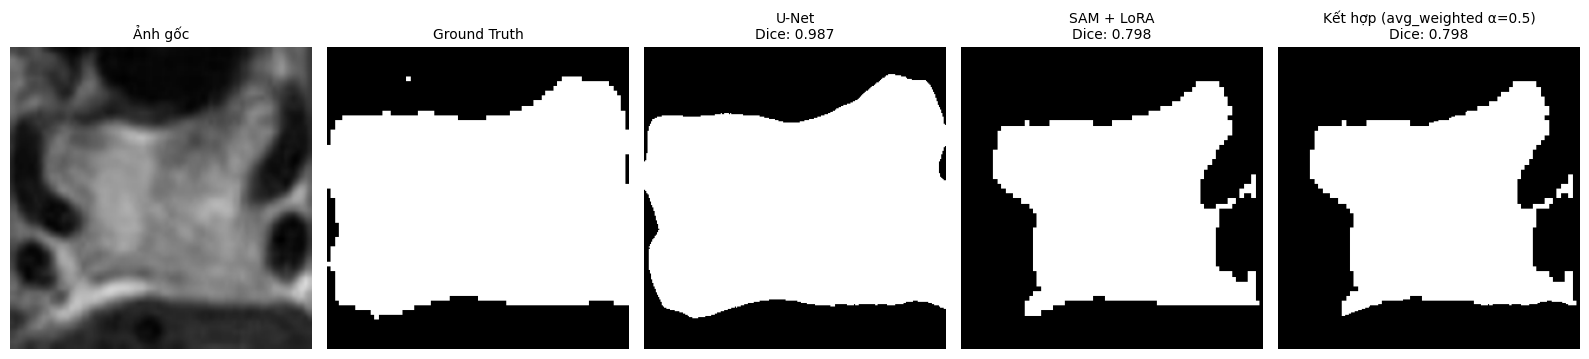

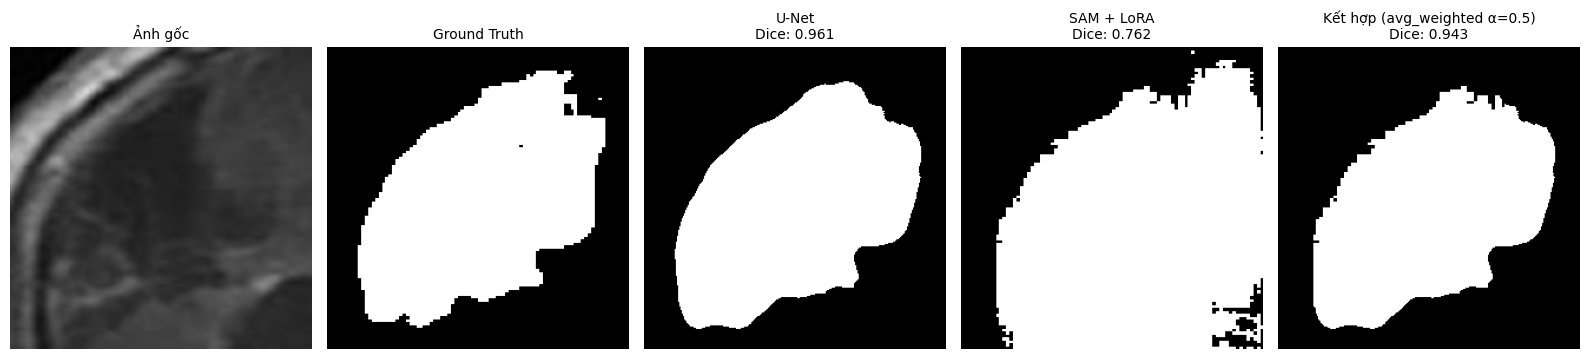


🔍 Thử kết hợp với alpha = 0.7


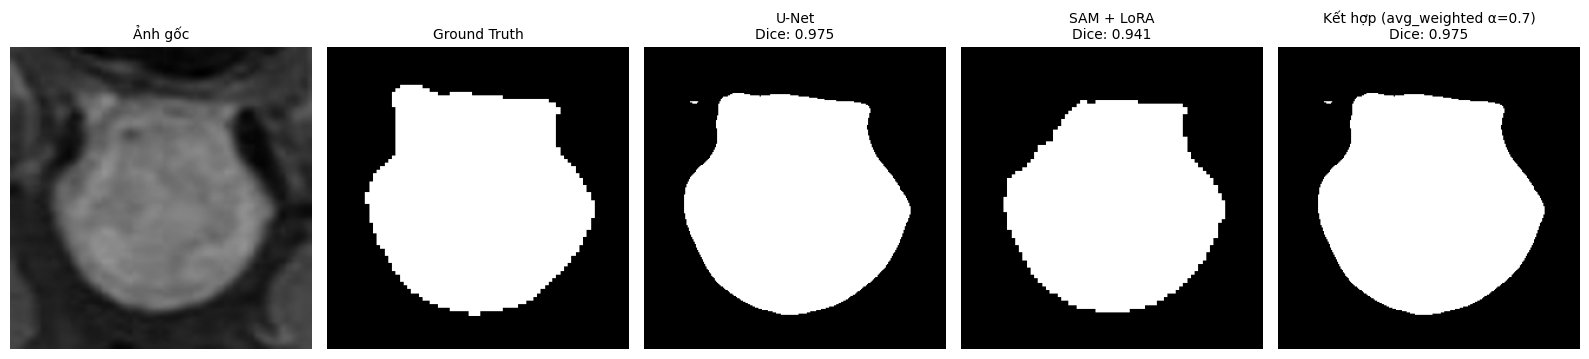

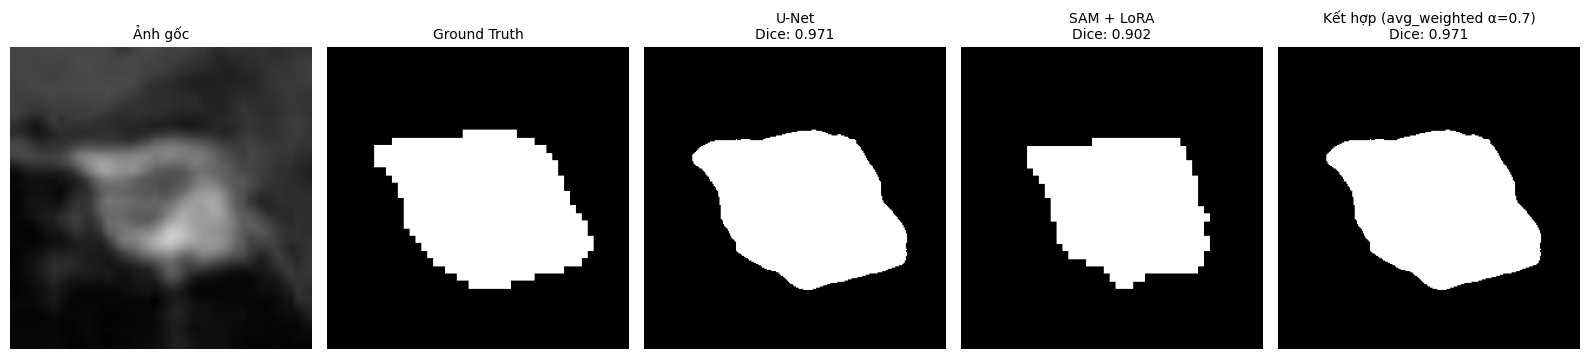


🔍 Thử kết hợp với alpha = 0.9


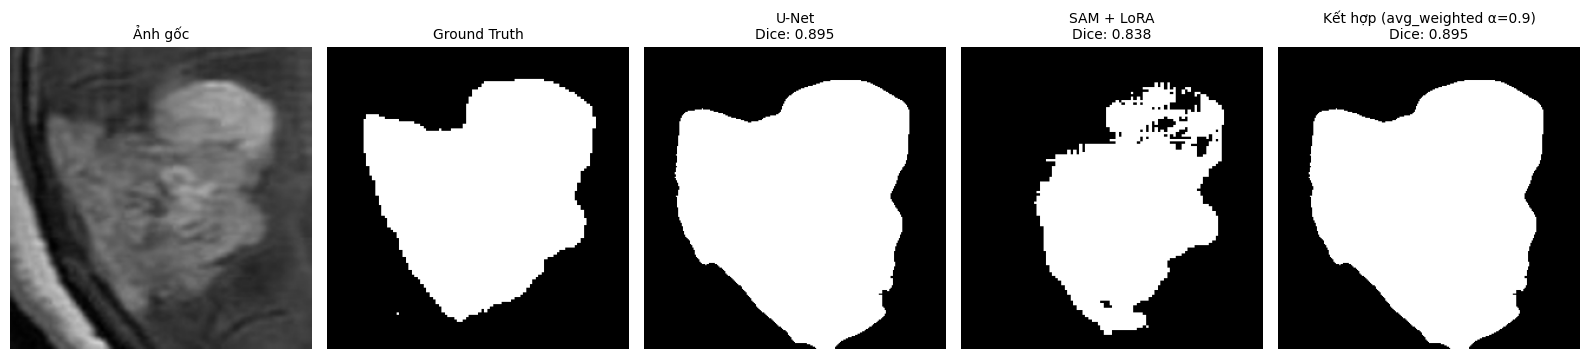

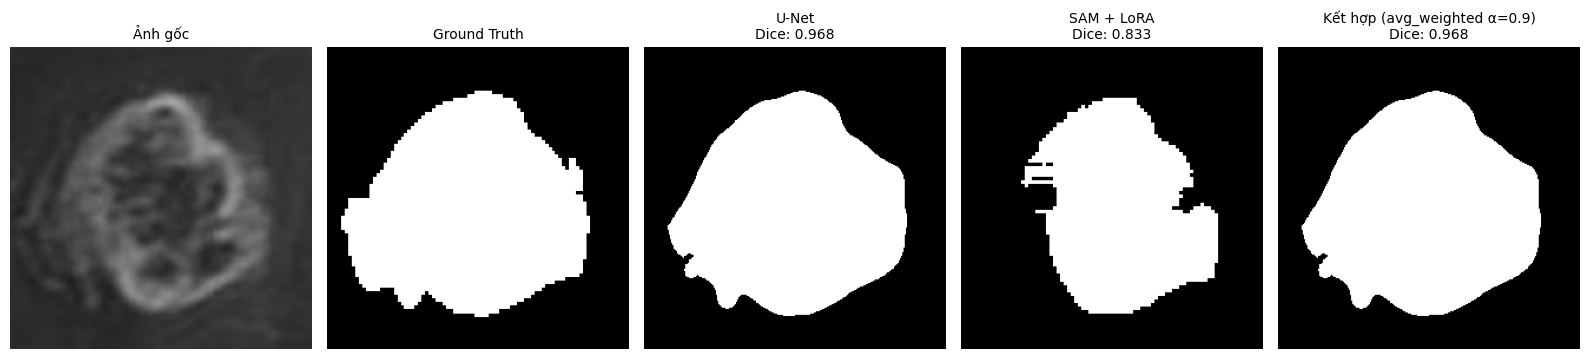

In [ ]:
for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(f"\n🔍 Thử kết hợp với alpha = {alpha}")
    compare_combined(val_images, val_masks, num_samples=2, combine_mode="avg_weighted", alpha=alpha)


In [ ]:
def compare_combined(val_images, val_masks, num_samples=5, display_size=(256, 256),
                     combine_mode="avg_weighted", alpha=0.5, fixed_indices=None):
    if fixed_indices is None:
        indices = np.random.choice(len(val_images), num_samples, replace=False)
    else:
        indices = fixed_indices

    for idx in indices:
        img_path = val_images[idx]
        mask_path = val_masks[idx]

        image_pil, mask_pil = load_image_mask_pair(img_path, mask_path)
        mask_np = np.array(mask_pil.resize(display_size, resample=Image.NEAREST)).astype(np.uint8)

        input_tensor = prepare_image_tensor(image_pil, target_size=display_size)
        pred_unet = predict_mask_unet(input_tensor, unet)
        pred_lora = predict_mask_sam(image_pil, sam_lora_predictor)
        pred_lora = cv2.resize(pred_lora.astype(np.uint8), display_size, interpolation=cv2.INTER_NEAREST)

        pred_combined = combine_masks(pred_unet, pred_lora, mode=combine_mode, alpha=alpha)

        image_resized = image_pil.resize(display_size)

        def compute_metrics(pred, gt):
            pred_bin = (pred > 0).astype(np.uint8)
            gt_bin = (gt > 0).astype(np.uint8)
            return {
                "Dice": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1),
                "IoU": jaccard_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=1)
            }

        metrics_unet = compute_metrics(pred_unet, mask_np)
        metrics_lora = compute_metrics(pred_lora, mask_np)
        metrics_comb = compute_metrics(pred_combined, mask_np)

        # Hiển thị
        titles = [
            "Ảnh gốc",
            "Ground Truth",
            f"U-Net\nDice: {metrics_unet['Dice']:.3f}",
            f"SAM + LoRA\nDice: {metrics_lora['Dice']:.3f}",
            f"Kết hợp α={alpha}\nDice: {metrics_comb['Dice']:.3f}"
        ]
        masks = [image_resized, mask_np, pred_unet, pred_lora, pred_combined]

        plt.figure(figsize=(16, 3.5))
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            ax.set_title(titles[i], fontsize=10)
            ax.axis("off")
            ax.imshow(masks[i] if i == 0 else masks[i], cmap=None if i == 0 else "gray")
        plt.tight_layout()
        plt.show()



🔍 Thử kết hợp với alpha = 0.1


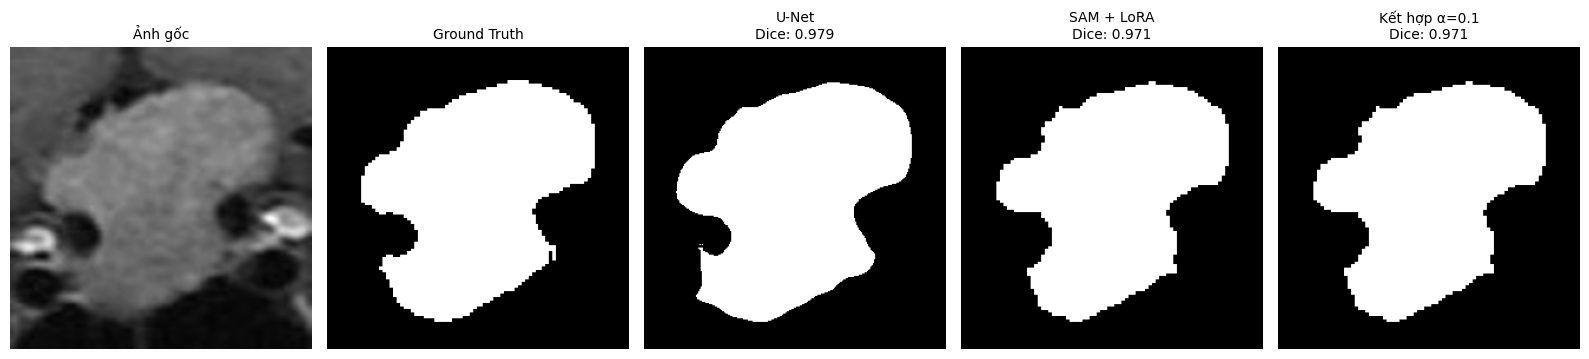

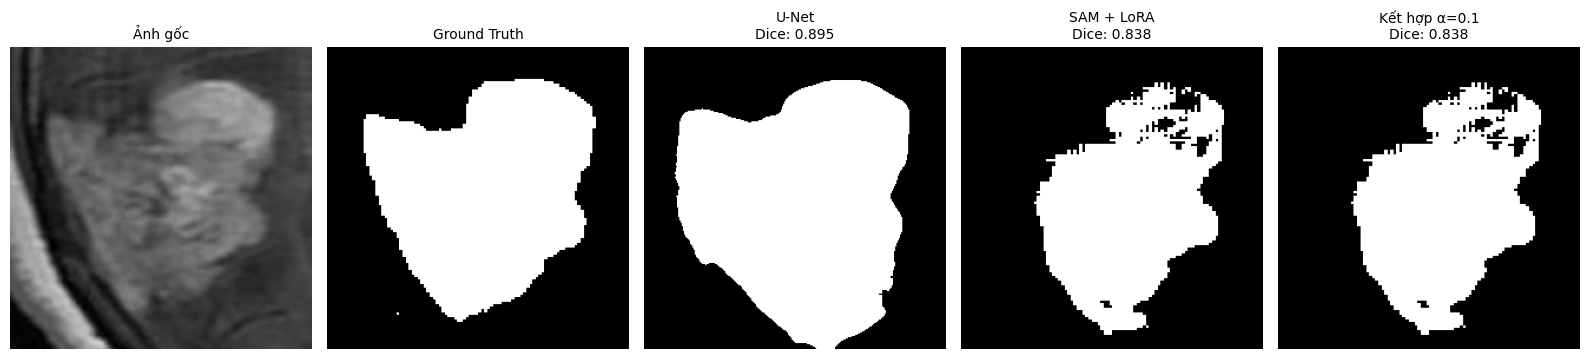


🔍 Thử kết hợp với alpha = 0.3


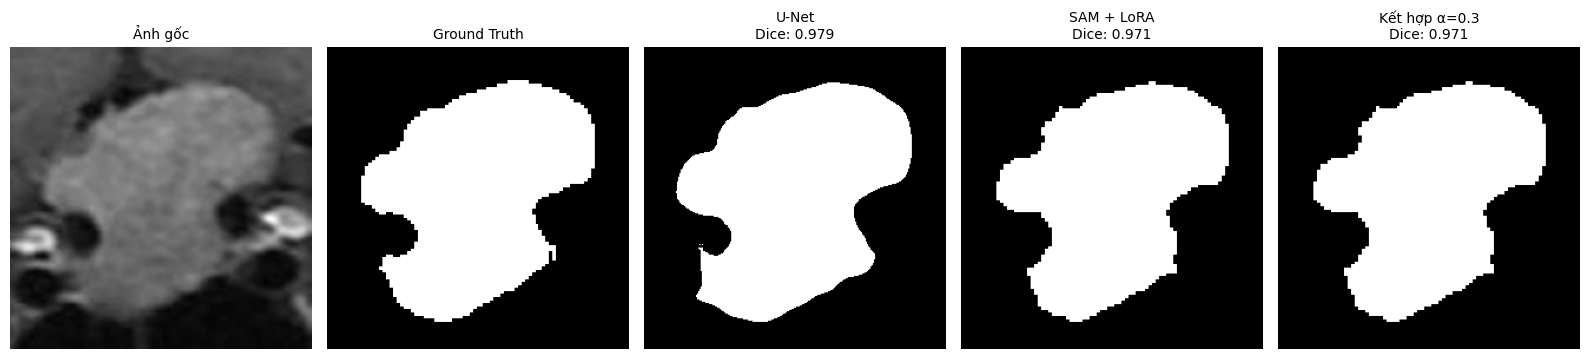

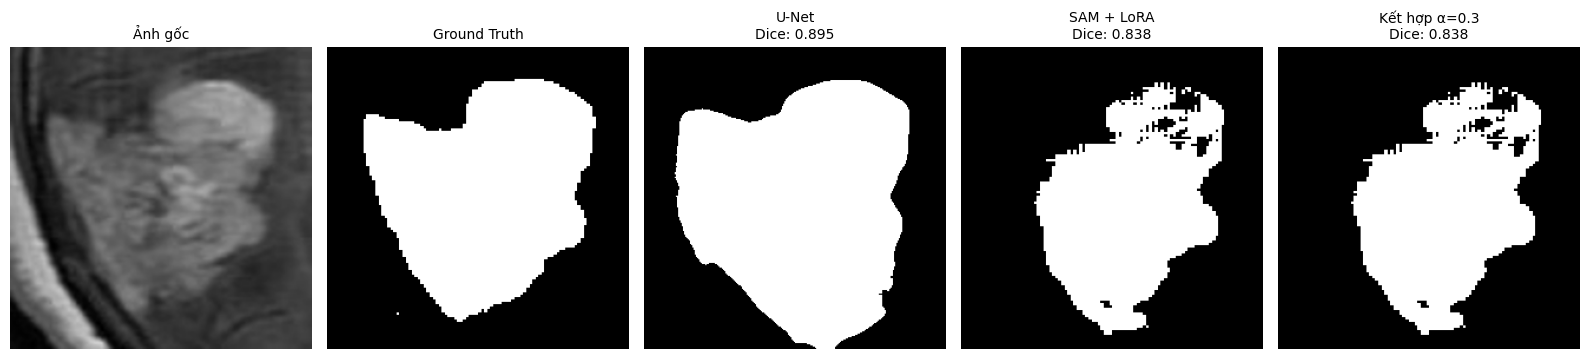


🔍 Thử kết hợp với alpha = 0.5


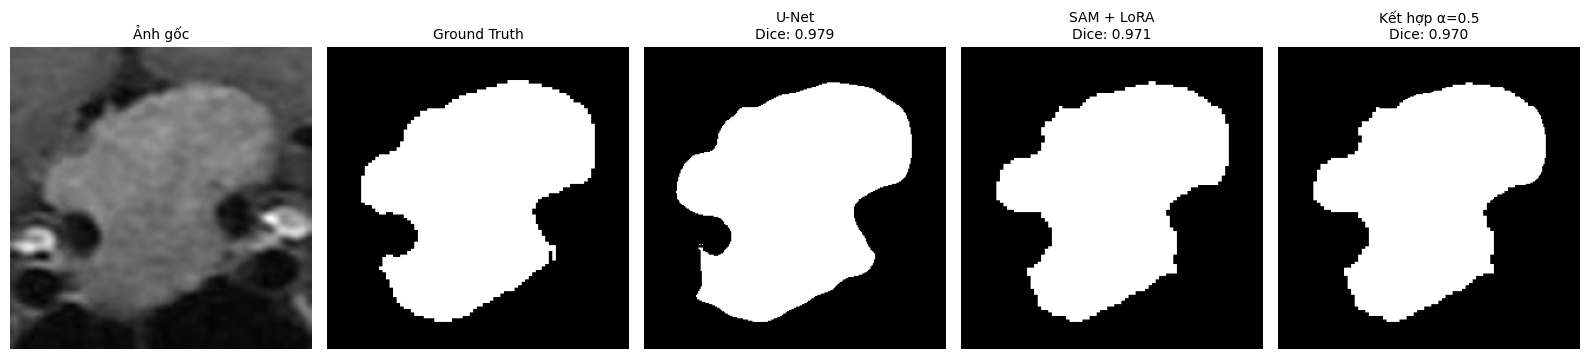

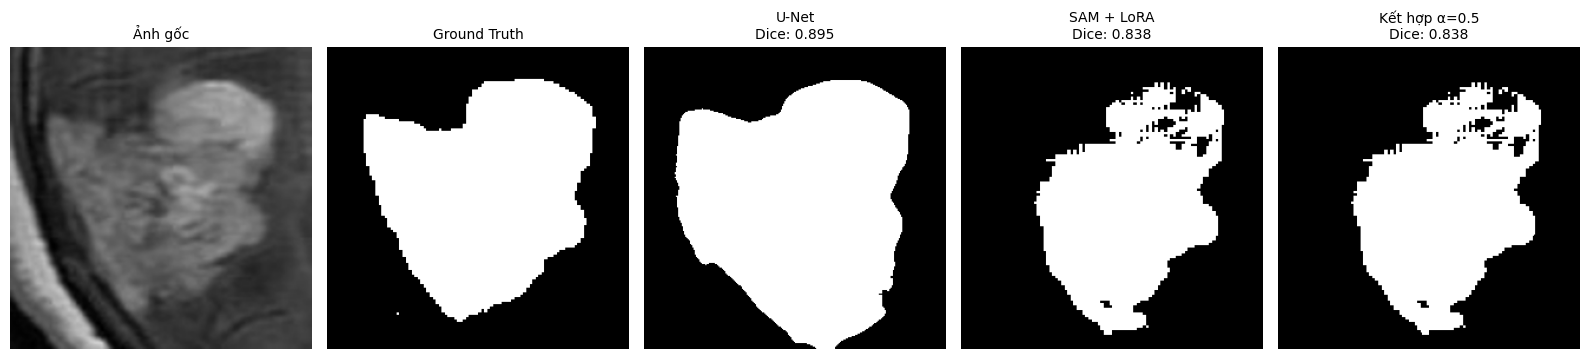


🔍 Thử kết hợp với alpha = 0.7


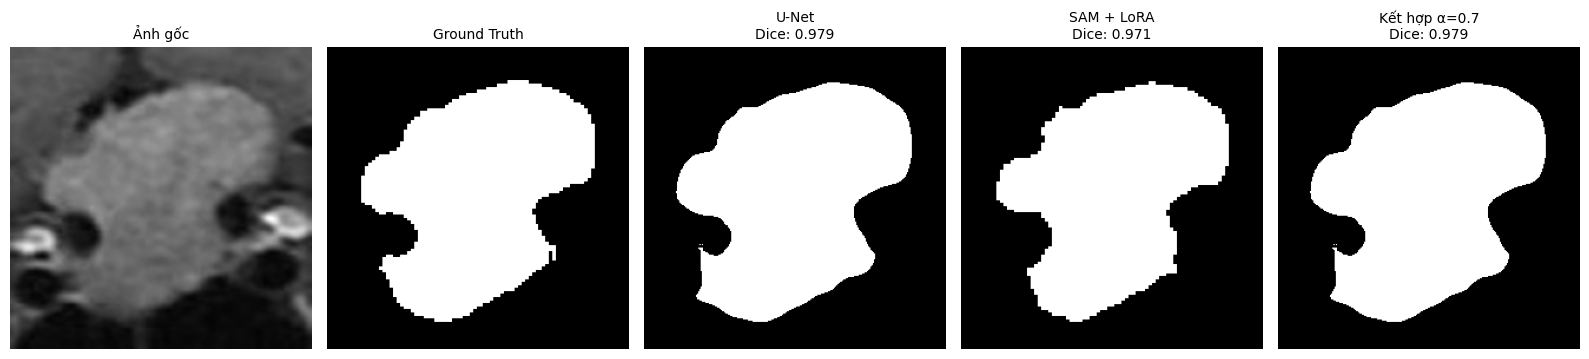

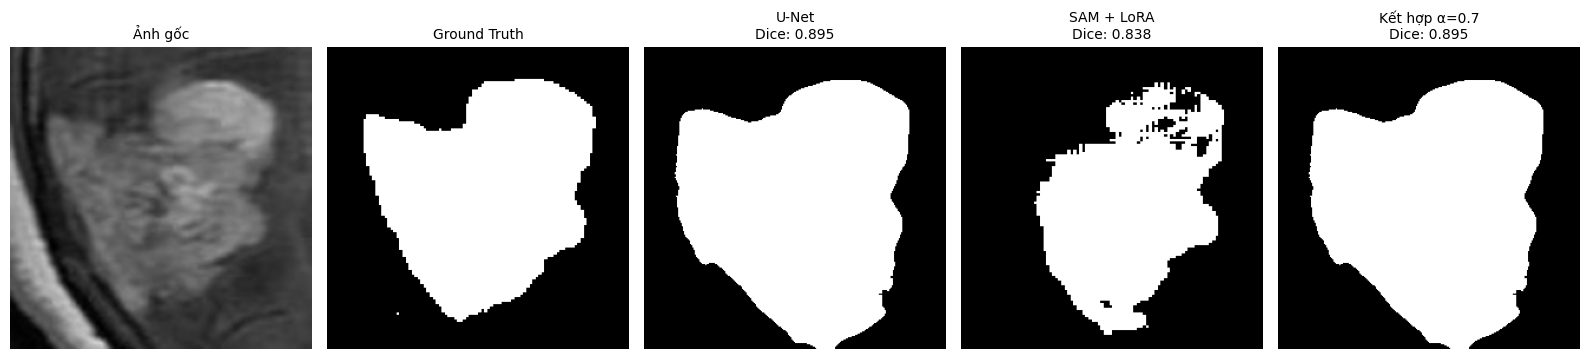


🔍 Thử kết hợp với alpha = 0.9


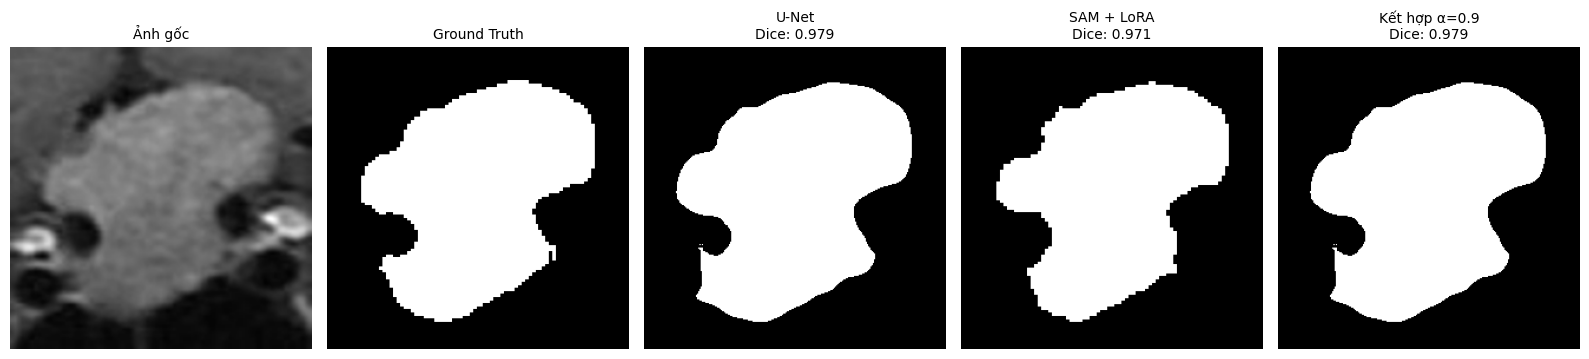

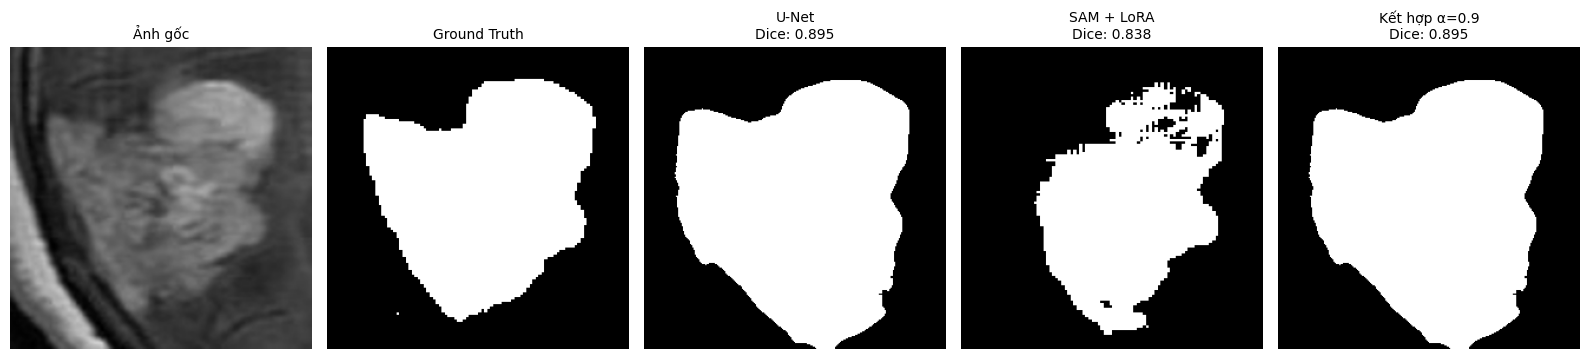

In [ ]:
# Chọn trước các index cố định
fixed_indices = np.random.choice(len(val_images), 2, replace=False)

# Thử nhiều alpha trên cùng 1 tập ảnh
for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(f"\n🔍 Thử kết hợp với alpha = {alpha}")
    compare_combined(val_images, val_masks,
                     num_samples=2,
                     combine_mode="avg_weighted",
                     alpha=alpha,
                     fixed_indices=fixed_indices)
